# Pre-processing of germline expression data

Create a dataset of gene intervals and relative expression level in the germline

In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Download germ cell expression groups from:

Xia, B., Yan, Y., Baron, M., Wagner, F., Barkley, D., Chiodin, M., Kim, S. Y., Keefe, D. L., Alukal, J. P., Boeke, J. D., & Yanai, I. (2020). Widespread Transcriptional Scanning in the Testis Modulates Gene Evolution Rates. Cell, 180(2), 248-262.e21. https://doi.org/10.1016/j.cell.2019.12.015

Table S6

In [2]:
%%bash 

mkdir -p data/gene4denovo/xia_et_al_expression_data
wget https://www.cell.com/cms/10.1016/j.cell.2019.12.015/attachment/08d8d7db-2f52-499b-999e-4be5d6316e71/mmc5.xlsx
mv mmc5.xlsx data/gene4denovo/xia_et_al_expression_data

--2021-11-10 15:04:15--  https://www.cell.com/cms/10.1016/j.cell.2019.12.015/attachment/08d8d7db-2f52-499b-999e-4be5d6316e71/mmc5.xlsx
Resolving www.cell.com (www.cell.com)... 104.18.124.114, 104.18.123.114
Connecting to www.cell.com (www.cell.com)|104.18.124.114|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://secure.jbs.elsevierhealth.com/action/getSharedSiteSession?redirect=https%3A%2F%2Fwww.cell.com%2Fcms%2F10.1016%2Fj.cell.2019.12.015%2Fattachment%2F08d8d7db-2f52-499b-999e-4be5d6316e71%2Fmmc5.xlsx&rc=0 [following]
--2021-11-10 15:04:15--  https://secure.jbs.elsevierhealth.com/action/getSharedSiteSession?redirect=https%3A%2F%2Fwww.cell.com%2Fcms%2F10.1016%2Fj.cell.2019.12.015%2Fattachment%2F08d8d7db-2f52-499b-999e-4be5d6316e71%2Fmmc5.xlsx&rc=0
Resolving secure.jbs.elsevierhealth.com (secure.jbs.elsevierhealth.com)... 104.18.124.114, 104.18.123.114
Connecting to secure.jbs.elsevierhealth.com (secure.jbs.elsevierhealth.com)|104.18.124.114|:443...

In [3]:
expr_dir = "data/gene4denovo/xia_et_al_expression_data"
gene_group_xlsx = os.path.join(expr_dir, "mmc5.xlsx")
expr_df = pd.read_excel(gene_group_xlsx, skiprows=2)
expr_df.head()

Group_Unexp     Group_1 Group_2  Group_3 Group_4 Group_5 Group_6  \
0     A3GALT2  AC006254.1    A1CF     A1BG   AADAT     A2M    AAAS   
1       A4GNT  AC007326.4   A2ML1   A4GALT   AARS2   AAED1    AACS   
2     AADACL2  AC010547.5   AADAC  AADACL4   ABCA1    AAMP   AAGAB   
3     AADACL3  AC021072.1   ABCB6    AANAT  ABCA12    AAR2    AAK1   
4    AATK-AS1  AC023509.3   ABCC9     AATK   ABCA2  AARSD1   AAMDC   

      Group_7 Group_8  
0       ABHD1   ACRBP  
1       ABHD2   ACTG1  
2        ABI2  ACTL7B  
3  AC010255.3   ADAD1  
4  AC010325.1   AGBL5

## Get GRCh37 coordinates for comparison with gene4denovo data

Xia et al. used ensembl version 90 so we'll use the following GFF file for analysis: 
    
    http://ftp.ensembl.org/pub/release-90/gff3/homo_sapiens/Homo_sapiens.GRCh38.90.gff3.gz

Also need to liftover coordinates to GRCh37. Implemented below in bash and perl

In [4]:
%%bash

LIFTOVER=~/bin/ucsc_tools/liftOver # EDIT to path of liftover on your system

cd data/gene4denovo/xia_et_al_expression_data
echo $(date) Downloading Ensembl release-90 GFF
wget http://ftp.ensembl.org/pub/release-90/gff3/homo_sapiens/Homo_sapiens.GRCh38.90.gff3.gz
echo $(date)  getting symbol to Ensembl gene ID conversions
perl -wanE 'next if /^#/;
            if ($F[2] eq "gene"){
                 if (m/ID=gene:(ENSG\d+);Name=([^;]+)\;/) {
                      say "$2\t$1" }
                 else { die "Could not parse line; $_\n";}}' <(zcat Homo_sapiens.GRCh38.90.gff3.gz ) > symbol2ensg.txt
echo $(date) converting gene lines to bed file  
perl -wanE \
    'next if /^#/;
     if ($F[2] eq "gene"){ 
         if (m/ID=gene:(ENSG\d+);Name=([^;]+)\;/) { 
             say join("\t", "chr$F[0]", $F[3] - 1, $F[4], "$2;$1", 0, $F[6]);
         } else {
             die "Could not parse line; $_\n";
         }
     }' <(zcat Homo_sapiens.GRCh38.90.gff3.gz) > Homo_sapiens.GRCh38.90.with_chr.bed

echo $(date) Getting liftover chain file
wget ftp://hgdownload.cse.ucsc.edu/goldenPath/hg38/liftOver/hg38ToHg19.over.chain.gz -O hg38ToHg19.over.chain.gz

echo $(date) Running liftOver for bed file from hg38 to hg19
mkdir -p hg19

$LIFTOVER Homo_sapiens.GRCh38.90.with_chr.bed \
    hg38ToHg19.over.chain.gz \
    hg19/Homo_sapiens.GRCh38.90.with_chr.hg19_lift.bed \
    hg19/Homo_sapiens.GRCh38.90.with_chr.hg19_lift.umap
echo $(date) stripping 'chr' prefix from liftover output
sed s/^chr// hg19/Homo_sapiens.GRCh38.90.with_chr.hg19_lift.bed \
    > hg19/Homo_sapiens.GRCh38.90.with_chr.hg19_lift.no_chr.bed
wc -l Homo_sapiens.GRCh38.90.with_chr.bed hg19/*
echo $(date) Finished
echo $?

Wed 10 Nov 15:04:18 GMT 2021 Downloading Ensembl release-90 GFF
Wed 10 Nov 15:04:32 GMT 2021 getting symbol to Ensembl gene ID conversions
Wed 10 Nov 15:04:35 GMT 2021 converting gene lines to bed file
Wed 10 Nov 15:04:38 GMT 2021 Getting liftover chain file
Wed 10 Nov 15:04:41 GMT 2021 Running liftOver for bed file from hg38 to hg19
Wed 10 Nov 15:04:42 GMT 2021 stripping chr prefix from liftover output
  21436 Homo_sapiens.GRCh38.90.with_chr.bed
  21245 hg19/Homo_sapiens.GRCh38.90.with_chr.hg19_lift.bed
  21245 hg19/Homo_sapiens.GRCh38.90.with_chr.hg19_lift.no_chr.bed
    382 hg19/Homo_sapiens.GRCh38.90.with_chr.hg19_lift.umap
  64308 total
Wed 10 Nov 15:04:42 GMT 2021 Finished
0


--2021-11-10 15:04:18--  http://ftp.ensembl.org/pub/release-90/gff3/homo_sapiens/Homo_sapiens.GRCh38.90.gff3.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.197.76
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.197.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37282619 (36M) [application/x-gzip]
Saving to: ‘Homo_sapiens.GRCh38.90.gff3.gz’

     0K .......... .......... .......... .......... ..........  0%  702K 52s
    50K .......... .......... .......... .......... ..........  0% 1.62M 37s
   100K .......... .......... .......... .......... ..........  0% 1.14M 35s
   150K .......... .......... .......... .......... ..........  0% 1.99M 31s
   200K .......... .......... .......... .......... ..........  0% 2.16M 28s
   250K .......... .......... .......... .......... ..........  0% 2.15M 26s
   300K .......... .......... .......... .......... ..........  0% 2.32M 24s
   350K .......... .......... .......... .......... ..........  1% 2.15M

### Excel has converted some gene names to dates in Xia et al. table S6 - identify and fix them 

In [5]:
date_re = re.compile(r'\d{4}-\d{2}-\d{2}')

group2gene = expr_df.melt(var_name='Group', value_name='Gene').dropna()
mask = group2gene.Gene.apply(lambda x: bool(date_re.match(str(x))))
group2gene[mask]

Group                 Gene
9945   Group_2  2019-03-01 00:00:00
9946   Group_2  2019-03-04 00:00:00
14323  Group_3  2019-12-01 00:00:00
14997  Group_3  2019-03-02 00:00:00
14998  Group_3  2019-03-01 00:00:00
15561  Group_3  2019-09-01 00:00:00
15562  Group_3  2019-09-05 00:00:00
20011  Group_4  2019-03-09 00:00:00
20887  Group_4  2019-09-11 00:00:00
20888  Group_4  2019-09-14 00:00:00
20889  Group_4  2019-09-03 00:00:00
20890  Group_4  2019-09-06 00:00:00
20891  Group_4  2019-09-08 00:00:00
25043  Group_5  2019-03-02 00:00:00
26259  Group_5  2019-09-09 00:00:00
29471  Group_6  2019-03-03 00:00:00
29472  Group_6  2019-03-05 00:00:00
30580  Group_6  2019-09-04 00:00:00
30581  Group_6  2019-09-07 00:00:00
32799  Group_7  2019-03-10 00:00:00
32800  Group_7  2019-03-11 00:00:00
32801  Group_7  2019-03-06 00:00:00
32802  Group_7  2019-03-07 00:00:00
32803  Group_7  2019-03-08 00:00:00
33204  Group_7  2019-09-10 00:00:00
33205  Group_7  2019-09-12 00:00:00
33206  Group_7  2019-09-02 00:00:00

In [6]:
mnth2str = {3: 'MARCH',
            9: 'SEPT',
            12: 'DEC'}

def date2gene(x):
    mnth = mnth2str[pd.to_datetime(x).month]
    day = pd.to_datetime(x).day
    return "{}{}".format(mnth, day)


group2gene['Symbol'] = group2gene.Gene.apply(lambda x: date2gene(x) if date_re.match(str(x)) else x)
group2gene[mask]

Group                 Gene   Symbol
9945   Group_2  2019-03-01 00:00:00   MARCH1
9946   Group_2  2019-03-04 00:00:00   MARCH4
14323  Group_3  2019-12-01 00:00:00     DEC1
14997  Group_3  2019-03-02 00:00:00   MARCH2
14998  Group_3  2019-03-01 00:00:00   MARCH1
15561  Group_3  2019-09-01 00:00:00    SEPT1
15562  Group_3  2019-09-05 00:00:00    SEPT5
20011  Group_4  2019-03-09 00:00:00   MARCH9
20887  Group_4  2019-09-11 00:00:00   SEPT11
20888  Group_4  2019-09-14 00:00:00   SEPT14
20889  Group_4  2019-09-03 00:00:00    SEPT3
20890  Group_4  2019-09-06 00:00:00    SEPT6
20891  Group_4  2019-09-08 00:00:00    SEPT8
25043  Group_5  2019-03-02 00:00:00   MARCH2
26259  Group_5  2019-09-09 00:00:00    SEPT9
29471  Group_6  2019-03-03 00:00:00   MARCH3
29472  Group_6  2019-03-05 00:00:00   MARCH5
30580  Group_6  2019-09-04 00:00:00    SEPT4
30581  Group_6  2019-09-07 00:00:00    SEPT7
32799  Group_7  2019-03-10 00:00:00  MARCH10
32800  Group_7  2019-03-11 00:00:00  MARCH11
32801  Group_7  2019-03-06 00:00:00   MARCH6
32802  Group_7  2019-03-07 00:00:00   MARCH7
32803  Group_7  2019-03-08 00:00:00   MARCH8
33204  Group_7  2019-09-10 00:00:00   SEPT10
33205  Group_7  2019-09-12 00:00:00   SEPT12
33206  Group_7  2019-09-02 00:00:00    SEPT2

### Get Ensembl IDs for genes

In [7]:
sym2ensg = pd.read_csv("data/gene4denovo/xia_et_al_expression_data/symbol2ensg.txt",
                       sep='\t',
                       names=['symbol', 'ensgene'])
sym2ensg = dict(zip(sym2ensg.symbol, sym2ensg.ensgene))
group2gene['Ensgene'] = group2gene.Symbol.astype(str).apply(lambda x: sym2ensg[x])
group2gene.head()

Group      Gene    Symbol          Ensgene
0  Group_Unexp   A3GALT2   A3GALT2  ENSG00000184389
1  Group_Unexp     A4GNT     A4GNT  ENSG00000118017
2  Group_Unexp   AADACL2   AADACL2  ENSG00000197953
3  Group_Unexp   AADACL3   AADACL3  ENSG00000188984
4  Group_Unexp  AATK-AS1  AATK-AS1  ENSG00000225180

In [8]:
group2gene.Group.unique()

array(['Group_Unexp', 'Group_1', 'Group_2', 'Group_3', 'Group_4',
       'Group_5', 'Group_6', 'Group_7', 'Group_8'], dtype=object)

In [9]:
group2gene['Expr_Group'] = group2gene.Group.apply(
    lambda x: 0 if x == 'Group_Unexp' else int(x.split('_')[1]))
group2gene.Expr_Group.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [10]:
bed_df = pd.read_csv(
    "data/gene4denovo/xia_et_al_expression_data/hg19/Homo_sapiens.GRCh38.90.with_chr.hg19_lift.no_chr.bed",
    sep='\t',
    names=['chrom', 'start', 'stop', 'name', 'score', 'strand'])
bed_df['Symbol'] = bed_df.name.apply(lambda x: x.split(';')[0])
bed_df['Ensgene'] = bed_df.name.apply(lambda x: x.split(';')[1])
bed_df['Expr_Group'] = bed_df.Symbol.apply(
    lambda x: group2gene[group2gene.Symbol == x]['Expr_Group'].values[0]
    if x in group2gene.Symbol.values else np.nan)
bed_df.head()

chrom      start       stop                    name  score strand  Symbol  \
0     1      65418      71585   OR4F5;ENSG00000186092      0      +   OR4F5   
1     5  180794268  180795263  OR4F29;ENSG00000284733      0      +  OR4F29   
2     1     621058     622053  OR4F16;ENSG00000284662      0      -  OR4F16   
3     1     859307     879961  SAMD11;ENSG00000187634      0      +  SAMD11   
4     1     879583     894689   NOC2L;ENSG00000188976      0      -   NOC2L   

           Ensgene  Expr_Group  
0  ENSG00000186092         0.0  
1  ENSG00000284733         0.0  
2  ENSG00000284662         0.0  
3  ENSG00000187634         4.0  
4  ENSG00000188976         6.0

<AxesSubplot:xlabel='Expr_Group', ylabel='count'>

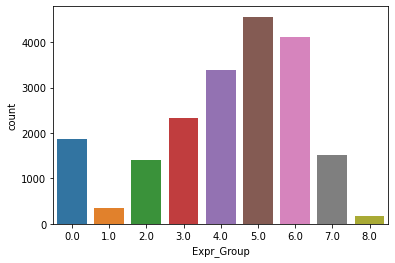

In [11]:
sns.countplot(data=bed_df, x='Expr_Group')

In [12]:
bed_df['Expr_Group_Broad'] = bed_df.Expr_Group.apply(
    lambda x: np.nan if np.isnan(x) else 'High' if x > 6
    else 'Mid' if x > 3 else 'Low' if x > 0 else 'Unexpressed')
bed_df.to_csv(
    "data/gene4denovo/xia_et_al_expression_data/hg19/Homo_sapiens.GRCh38.90.with_chr.hg19_lift.no_chr.germline_expression.tsv",
    index=False,
    sep='\t')
bed_df.head()

chrom      start       stop                    name  score strand  Symbol  \
0     1      65418      71585   OR4F5;ENSG00000186092      0      +   OR4F5   
1     5  180794268  180795263  OR4F29;ENSG00000284733      0      +  OR4F29   
2     1     621058     622053  OR4F16;ENSG00000284662      0      -  OR4F16   
3     1     859307     879961  SAMD11;ENSG00000187634      0      +  SAMD11   
4     1     879583     894689   NOC2L;ENSG00000188976      0      -   NOC2L   

           Ensgene  Expr_Group Expr_Group_Broad  
0  ENSG00000186092         0.0      Unexpressed  
1  ENSG00000284733         0.0      Unexpressed  
2  ENSG00000284662         0.0      Unexpressed  
3  ENSG00000187634         4.0              Mid  
4  ENSG00000188976         6.0              Mid

<AxesSubplot:xlabel='Expr_Group_Broad', ylabel='count'>

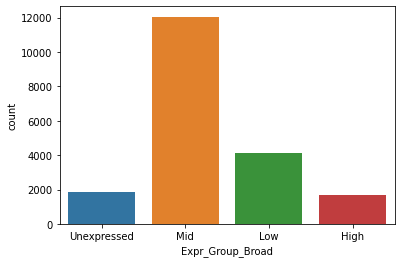

In [13]:
sns.countplot(data=bed_df, x='Expr_Group_Broad')

In [14]:
def expression_lookup(row):
    res = bed_df[(bed_df.chrom == row.chrom) &
                 (bed_df.start < row.pos) &
                 (bed_df.stop >= row.pos)]
    if len(res) > 0:
        max_tmp = res.iloc[res['Expr_Group'].argmax()]
        return pd.Series([max_tmp.Symbol,
                          max_tmp.Ensgene,
                          max_tmp.strand,
                          max_tmp.Expr_Group])    
    return pd.Series([np.nan, np.nan, np.nan, np.nan])

In [15]:
indel_df = pd.read_csv(
    "data/gene4denovo/gene4denovo_indels.csv",
    dtype={'chrom': str, 'pos': int})
indel_df[['Symbol', 'Ensgene', 'Strand', 'Expression_Group']] = indel_df.apply(
    expression_lookup,
    axis=1)
indel_df['Expr_Group_Broad'] = indel_df.Expression_Group.apply(
    lambda x: np.nan if np.isnan(x) else 'High' if x > 6
    else 'Mid' if x > 3 else 'Low' if x > 0 else 'Unexpressed')
indel_df.to_csv(
    "data/gene4denovo/gene4denovo_indels_with_germline_expression.csv",
    index=False)
indel_df.head()

chrom        pos  qual    ref       alt  n_alleles variant_type repeat_type  \
0     1  217847741   NaN   TAGG         T          2          Del     Perfect   
1     2  164875949   NaN  TTTTA         T          2          Del     Perfect   
2    11  106845486   NaN  CAGAG         C          2          Del     Perfect   
3     4   91938901   NaN     TC         T          2          Del   No repeat   
4    13   35751685   NaN      C  CGGTATCT          2          Ins   No repeat   

  repeat_unit  repeat_length  ... variant_length  cosmic_class transcribed  \
0         AGG              9  ...              3     3:Del:R:2        True   
1        TTTA              8  ...              4     4:Del:R:1        True   
2        AGAG              8  ...              4     4:Del:R:1        True   
3         NaN              0  ...              1     1:Del:C:0        True   
4         NaN              0  ...              7     5:Ins:R:0        True   

   transcribed_strand Simple_Categorization   Symbol          Ensgene Strand  \
0               Sense       2-5 bp deletion  SPATA17  ENSG00000162814      +   
1           Antisense       2-5 bp deletion      NaN              NaN    NaN   
2           Antisense       2-5 bp deletion  GUCY1A2  ENSG00000152402      -   
3               Sense         1 bp deletion   CCSER1  ENSG00000184305      +   
4               Sense      > 5 bp insertion     NBEA  ENSG00000172915      +   

  Expression_Group  Expr_Group_Broad  
0              7.0              High  
1              NaN               NaN  
2              4.0               Mid  
3              6.0               Mid  
4              6.0               Mid  

[5 rows x 21 columns]